In [1]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
from kinetic.evaluation import *
from kinetic.utils import select_model
from kinetic.config import get_custom_cfg
from kinetic.data import *
from torchdeepretina.utils import *
from kinetic.notebook.functions import *

In [12]:
device = torch.device('cuda:0')
model = KineticsChannelModel().to(device)
cfg = get_custom_cfg('channel')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel/epoch_080_loss_-3.33_pearson_0.4375.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.001)

In [4]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.5757067525839287

In [5]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1, shuffle=True)
test_pc, _, _ = pearsonr_eval(model, test_data, 5, device)
test_pc

0.15161894836633308

In [11]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [ 1.0000]], device='cuda:1')
kinetics.kfi tensor([[ 0.9982],
        [ 0.9220],
        [ 0.9997],
        [ 0.8444],
        [ 0.9985],
        [ 0.2441],
        [-0.9991],
        [ 0.9999]], device='cuda:1')
kinetics.kfr tensor([[-1.0000],
        [-0.9783],
        [ 0.6897],
        [ 0.6736],
        [ 1.0000],
        [-0.8782],
        [ 1.0000],
        [ 0.9782]], device='cuda:1')
kinetics.ksi tensor([[-8.0042e-05],
        [ 5.8578e-04],
        [ 1.5829e-04],
        [-1.5062e-04],
        [ 2.6461e-03],
        [ 5.4800e-04],
        [ 8.2148e-04],
        [ 1.5230e-04]], device='cuda:1')
kinetics.ksr tensor([[-8.3430e-06],
        [-7.4978e-06],
        [ 5.8411e-06],
        [ 2.1855e-06],
        [-1.8767e-05],
        [-6.5332e-07],
        [-7.8537e-06],
        [ 1.7386e-05]], device='cuda:1')


(0, 1)

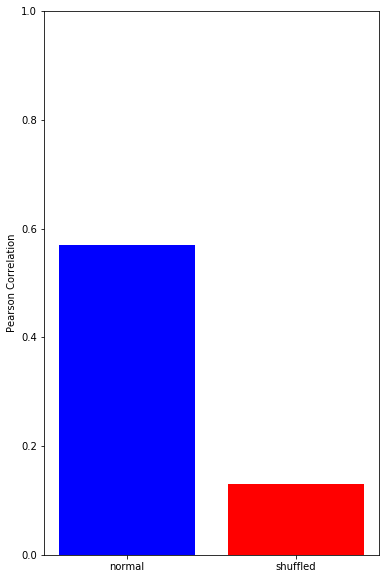

In [24]:
fig, ax = plt.subplots(figsize=(6,10))
rects1 = ax.bar(['normal', 'shuffled'], [0.57, 0.13], color=['blue', 'red'])
ax.set_ylabel('Pearson Correlation')
ax.set_ylim([0, 1])

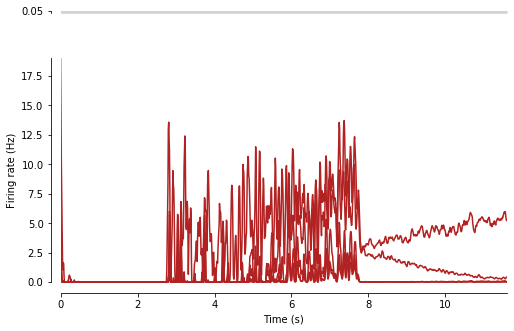

In [10]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=500, delay=300, nsamples=1200, nrepeats=3)

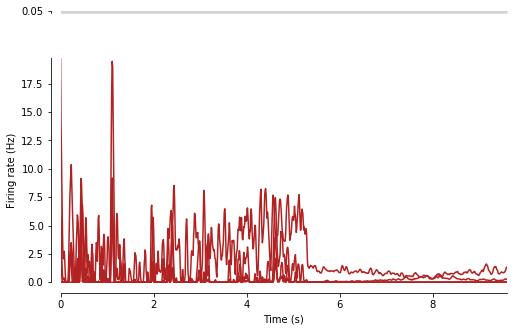

In [13]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3)

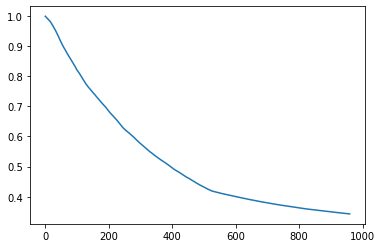

In [14]:
plt.plot(np.arange(960),Rs)

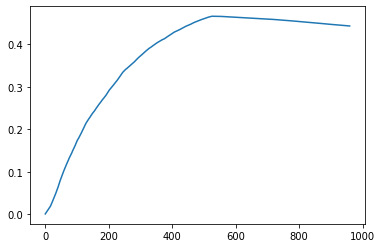

In [15]:
plt.plot(np.arange(960),As)

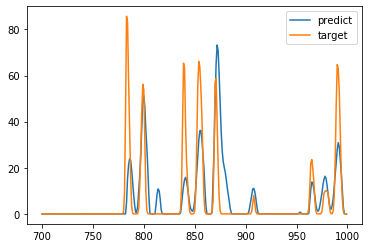

In [12]:
plt.plot(np.arange(700,1000),pred[700:1000,3], label='predict')
plt.plot(np.arange(700,1000),targ[700:1000,3], label='target')
plt.legend()

In [7]:
targ.shape

(5956, 5)

In [6]:
test_dataset = TestDataset(cfg)
batch_sampler = BatchRnnSampler(length=len(test_dataset), batch_size=1, seq_len=cfg.Data.seq_len)
test_data = DataLoader(dataset=test_dataset, batch_sampler=batch_sampler)

In [16]:
def inspect_rnn(model, curr_hs, data, device=torch.device('cuda:1')):
    hs = []
    hs.append(curr_hs[0].detach())
    hs.append(deque([h.detach() for h in curr_hs[1]], maxlen=model.seq_len))
    data = data.to(device)
    for x in data:
        x = x[None,:,:,:]
        out, hs = model(x, hs)
    return out

def stimulus_importance_rnn(model, X, gc_idx=None, alpha_steps=5, 
                            seq_len=8, device=torch.device('cuda:1')):
    
    requires_grad(model, False) # Model gradient unnecessary for integrated gradient
    prev_grad_state = torch.is_grad_enabled() # Save current grad calculation state
    torch.set_grad_enabled(True) # Enable grad calculations
    
    if gc_idx is None:
        gc_idx = list(range(model.n_units))
    intg_grad = torch.zeros(seq_len, *model.image_shape)
    curr_hs = get_hs(model, 1, device)
    model = model.to(device)
    model.eval()
    X = torch.FloatTensor(X)
    X.requires_grad = True
    idxs = torch.arange(len(X)).long()
    for start_idx in range(0, len(X) - seq_len):
        linspace = torch.linspace(0,1,alpha_steps)
        idx = idxs[start_idx: start_idx + seq_len]
        with torch.no_grad():
            out, next_hs = model(X[start_idx][None,:,:,:].to(device), curr_hs)
        curr_intg_grad = torch.zeros(seq_len, *model.image_shape)
        for alpha in linspace:
            x = X[idx].to(device) * alpha
            outs = inspect_rnn(model, curr_hs, x)[:,gc_idx]
            grad = torch.autograd.grad(outs.sum(), x)[0]
            grad = grad.detach().cpu().reshape(*intg_grad.shape)
            act = X[idx].detach().cpu()
            curr_intg_grad += grad*act
        intg_grad += torch.mul(curr_intg_grad, curr_intg_grad) / (len(X) - seq_len)
        curr_hs = next_hs
            
    requires_grad(model, True)
    torch.set_grad_enabled(prev_grad_state)
    
    intg_grad = intg_grad.view(seq_len * model.image_shape[0], *model.image_shape[1:])
    intg_grad = torch.mean(intg_grad, dim=(1,2))
    intg_grad = torch.sqrt(intg_grad)
    intg_grad = intg_grad.data.cpu().numpy()
    return intg_grad

In [15]:
data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'test',
                        cfg.img_shape[0], 0, data_path=cfg.Data.data_path)
X = data.X[0:1000]
intg_grad = stimulus_importance_rnn(model, X, alpha_steps=5)

[Text(0, 0.5, 'Importance'), Text(0.5, 0, 't / frame')]

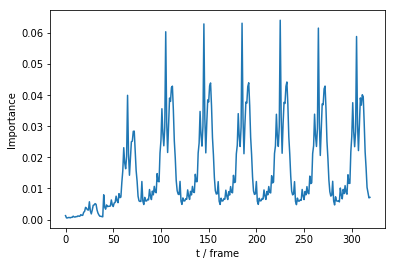

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(320), intg_grad)
ax.set(xlabel='t / frame', ylabel='Importance')

In [16]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter/epoch_10_loss_-27.42987749385597_pearson_0.45068423074452113.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilter(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0

In [15]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.6206136571195842

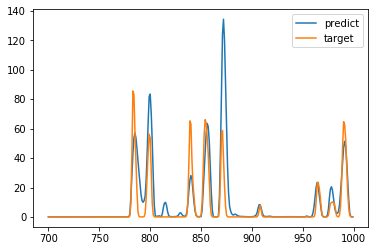

In [16]:
plt.plot(np.arange(700,1000),pred[700:1000,3], label='predict')
plt.plot(np.arange(700,1000),targ[700:1000,3], label='target')
plt.legend()

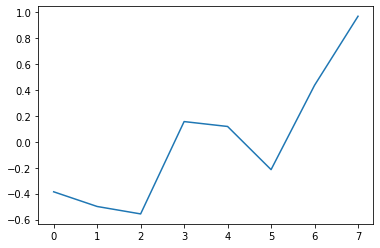

In [15]:
filter = checkpoint['model_state_dict']['amacrine.1.filter'].cpu().numpy().squeeze()
plt.plot(np.arange(8),filter)

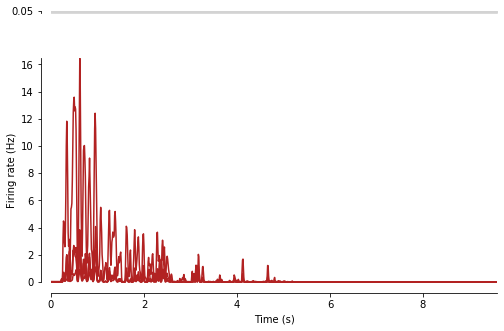

In [17]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=10)

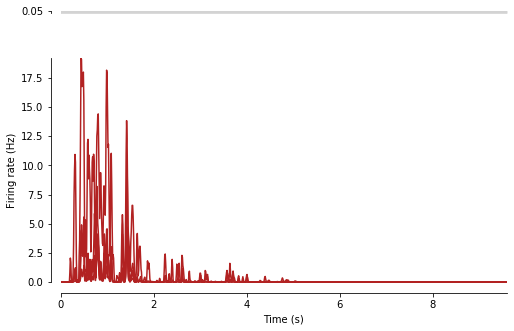

In [6]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3)

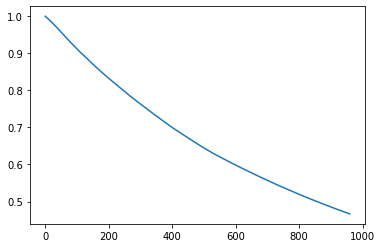

In [8]:
plt.plot(np.arange(960),Rs)

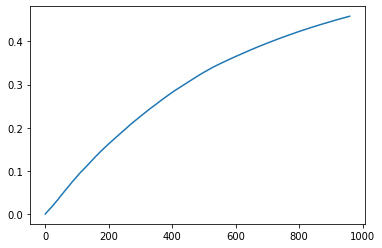

In [9]:
plt.plot(np.arange(960),As)

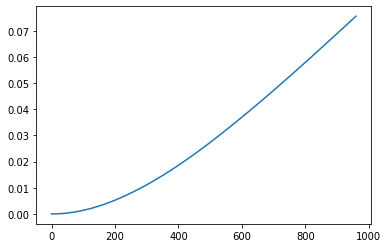

In [10]:
plt.plot(np.arange(960),I1s)

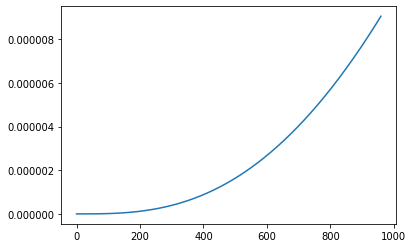

In [11]:
plt.plot(np.arange(960),I2s)

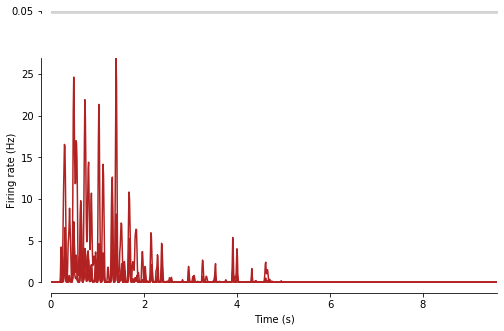

In [22]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_occupancy(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3)

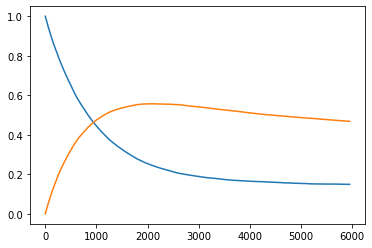

In [19]:
plt.plot(np.arange(960),Rs)
plt.plot(np.arange(960),As)

In [17]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy_natural(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

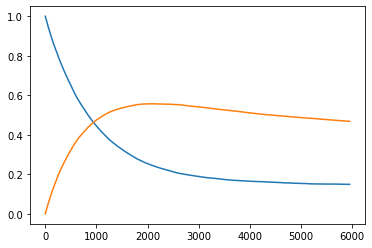

In [20]:
plt.plot(np.arange(5956),Rs)
plt.plot(np.arange(5956),As)

In [11]:
test_data[1][0].shape

torch.Size([40, 50, 50])

In [5]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[1.5426],
        [0.3703],
        [0.9160],
        [0.9499],
        [0.9340],
        [0.9816],
        [1.2149],
        [0.9078]], device='cuda:0')
kinetics.kfi tensor([[-0.2491],
        [ 0.4618],
        [ 0.2080],
        [ 0.4353],
        [ 0.4470],
        [ 0.3863],
        [ 0.2987],
        [ 0.2215]], device='cuda:0')
kinetics.kfr tensor([[ 8.0158e-01],
        [ 7.1081e-04],
        [-5.1790e-01],
        [ 9.2692e-01],
        [ 4.2982e-03],
        [ 6.4378e-01],
        [ 7.7946e-01],
        [-3.6091e-01]], device='cuda:0')
kinetics.ksi tensor([[-5.9985e-04],
        [-4.0659e-06],
        [-9.8312e-05],
        [ 3.2299e-04],
        [-1.3978e-05],
        [-4.8541e-04],
        [ 7.2575e-04],
        [-3.3857e-04]], device='cuda:0')
kinetics.ksr tensor([[ 1.4934e-06],
        [-4.0375e-11],
        [-1.0972e-06],
        [-1.0833e-05],
        [-8.4881e-11],
        [ 3.2628e-06],
        [ 1.4778e-05],
        [-3.9474e-08]], device='cuda:0'

In [2]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_slow')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_slow/epoch_002_loss_-2.99_pearson_0.4736.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilter(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0

In [6]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[0.9475],
        [0.8159],
        [0.9771],
        [0.7919],
        [0.9453],
        [0.8805],
        [0.9745],
        [0.8654]], device='cuda:3')
kinetics.kfi tensor([[-0.4885],
        [ 0.0040],
        [ 0.1654],
        [ 0.5738],
        [ 0.5581],
        [ 0.5137],
        [ 0.5351],
        [ 0.0793]], device='cuda:3')
kinetics.kfr tensor([[ 0.0073],
        [ 1.0506],
        [-1.0630],
        [ 1.3895],
        [ 0.0185],
        [ 1.1836],
        [ 0.4049],
        [-0.9492]], device='cuda:3')
kinetics.ksi tensor([[-6.1182e-01],
        [-2.2900e-04],
        [-4.4565e-03],
        [-7.2793e-03],
        [-3.1899e-01],
        [ 4.0868e-03],
        [ 3.6434e-01],
        [ 4.3367e-03]], device='cuda:3')
kinetics.ksr tensor([[-2.5764e-04],
        [-2.4422e-01],
        [-2.9915e-01],
        [-1.5847e-01],
        [ 1.0186e-01],
        [ 2.7667e-01],
        [-6.5591e-03],
        [ 4.0603e-01]], device='cuda:3')


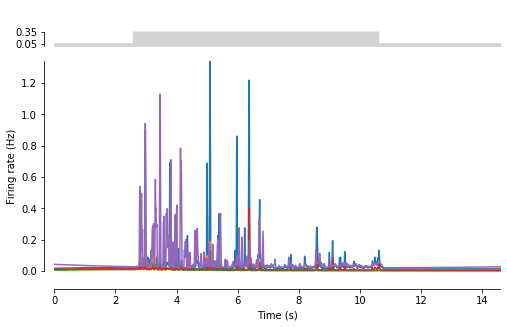

In [4]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

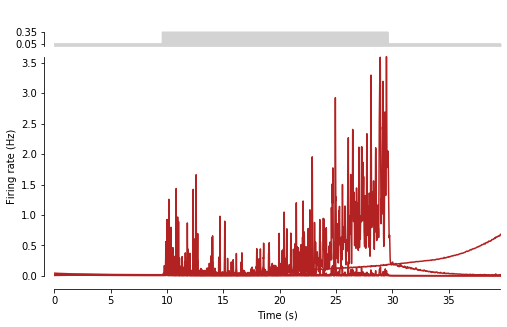

In [7]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

In [12]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

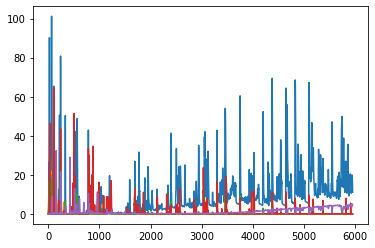

In [15]:
plt.plot(np.arange(responses.shape[0]), responses)

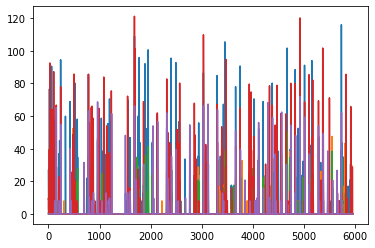

In [16]:
plt.plot(np.arange(targets.shape[0]), targets)

In [18]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural_reset(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

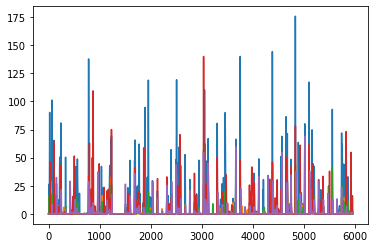

In [19]:
plt.plot(np.arange(responses.shape[0]), responses)

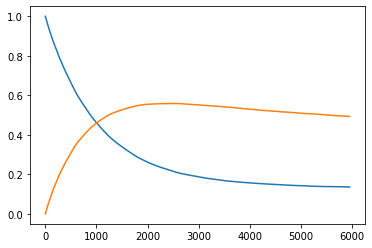

In [10]:
plt.plot(np.arange(5956),Rs)
plt.plot(np.arange(5956),As)

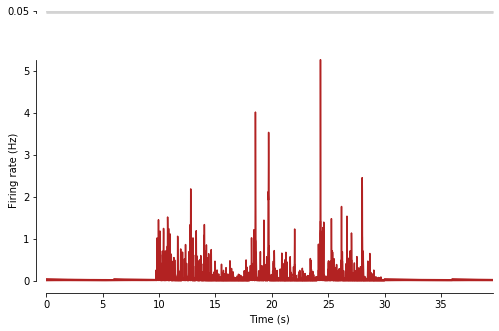

In [24]:
figs, envelope, responses = contrast_adaptation_kinetic_reset(model, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

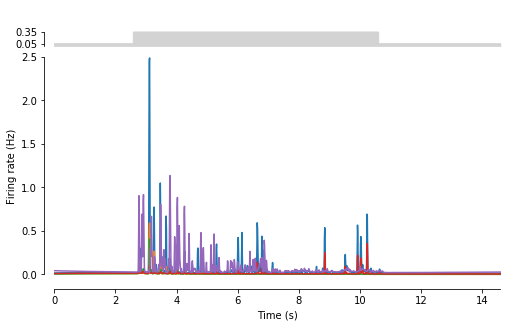

In [4]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_occupancy(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

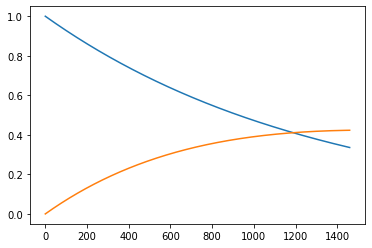

In [6]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

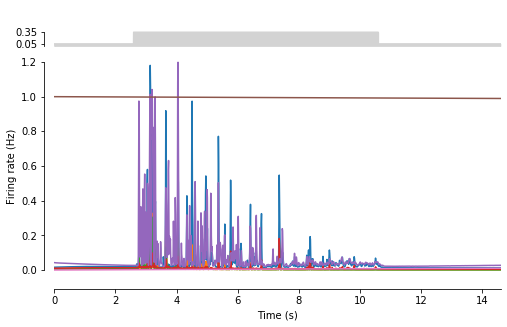

In [7]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

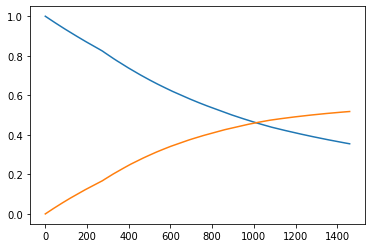

In [8]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

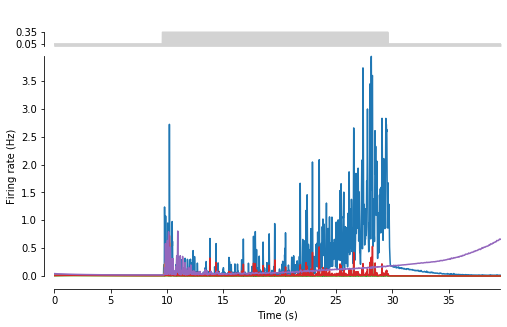

In [7]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

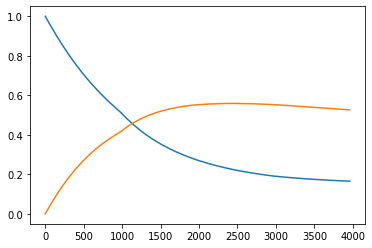

In [8]:
plt.plot(np.arange(3960),Rs)
plt.plot(np.arange(3960),As)

In [5]:
Rs = contrast_adaptation_kinetic_center_deviation(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

(array([8679.,  509.,  229.,  180.,  150.,  215.,  122.,  147.,   85.,
          52.]),
 array([  0.        ,  60.89805123, 121.79610246, 182.69415369,
        243.59220492, 304.49025615, 365.38830738, 426.28635861,
        487.18440984, 548.08246107, 608.9805123 ]),
 <a list of 10 Patch objects>)

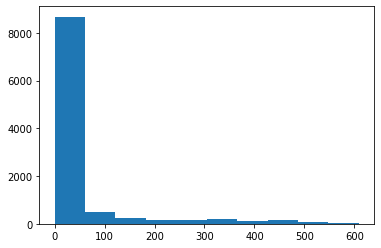

In [6]:
plt.hist(Rs.flatten())

In [9]:
int(np.where(Rs==Rs.max())[0])

7

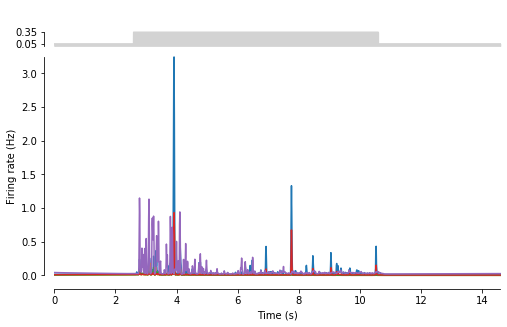

In [10]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_where_occupancy(model, device, c0=0.05, c1=0.35, where=(7,444), duration=800, delay=300, nsamples=1500, nrepeats=10)

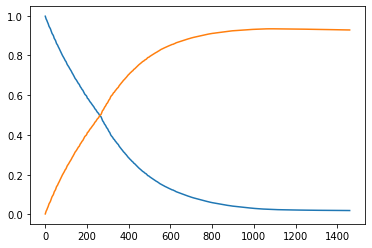

In [20]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

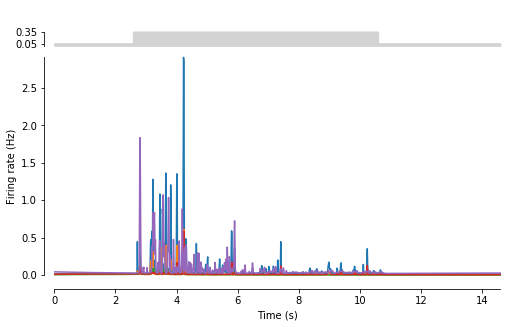

In [5]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_deviation_response(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

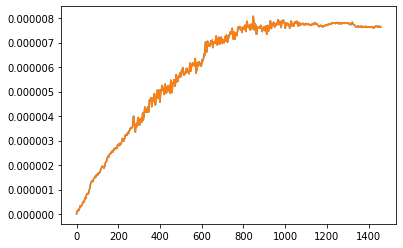

In [6]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

In [5]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.6460017342818717

In [21]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.35493691587280857

In [26]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter/epoch_000_loss_-3.62_pearson_0.3106.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilter(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0

In [27]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 0.2476],
        [ 0.2984],
        [ 0.2601],
        [ 0.3803],
        [-0.2862],
        [ 0.3108],
        [ 0.1854],
        [ 0.4013]], device='cuda:3')
kinetics.kfi tensor([[ 0.2727],
        [ 0.3502],
        [-0.2269],
        [ 0.4591],
        [ 0.4344],
        [ 0.1888],
        [ 0.2028],
        [ 0.4333]], device='cuda:3')
kinetics.kfr tensor([[ 0.5342],
        [ 0.6027],
        [ 0.4570],
        [-0.8636],
        [-0.6855],
        [ 0.4705],
        [ 0.4249],
        [ 0.8834]], device='cuda:3')
kinetics.ksi tensor([[-0.0010],
        [-0.0006],
        [-0.0109],
        [-0.0108],
        [-0.0269],
        [ 0.0024],
        [-0.0018],
        [ 0.0164]], device='cuda:3')
kinetics.ksr tensor([[-1.6730e-04],
        [ 6.9761e-04],
        [-5.9080e-07],
        [ 2.1044e-03],
        [-3.6113e-04],
        [ 3.1455e-04],
        [-1.1778e-05],
        [ 4.5210e-03]], device='cuda:3')


In [2]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_bipolar')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_bipolar/epoch_025_loss_-17.86_pearson_0.3723.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.01)
  (kinet_scale): ScaleShift(shape=(8, 8, 1296)

In [4]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[31.2726],
        [31.2117],
        [34.8675],
        [35.4234],
        [31.8742],
        [36.8238],
        [34.0536],
        [33.2273]], device='cuda:3')
kinetics.kfi tensor([[33.7959],
        [34.4847],
        [33.3592],
        [33.1968],
        [33.4390],
        [33.0275],
        [33.5766],
        [33.7233]], device='cuda:3')
kinetics.kfr tensor([[70.6656],
        [70.7384],
        [70.7003],
        [70.7160],
        [70.6706],
        [70.7848],
        [70.7572],
        [70.6729]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


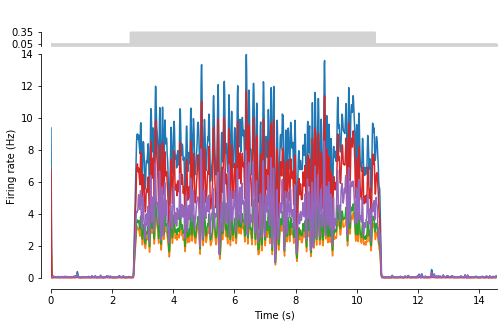

In [3]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

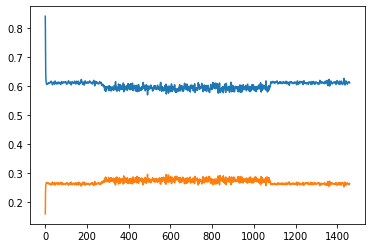

In [5]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

In [6]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.48912265832638663

In [9]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5500, device)
test_pc

0.4917588819835769